In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import warnings
warnings.filterwarnings('ignore')

## Part 1: Data Cleaning

Benign CSVs

In [2]:
benignChrome = pd.read_csv("./BenignDoH-NonDoH-CSVs/CSVs/Chrome/all.csv")
benignFirefox = pd.read_csv("./BenignDoH-NonDoH-CSVs/CSVs/Firefox/all.csv")

In [3]:
# benignChrome.head()

In [4]:
# benignFirefox.head()

Malicious CSVs

In [3]:
dns2tcp = pd.read_csv("./MaliciousDoH-CSVs/CSVs/dns2tcp/all.csv")
dnscat2 = pd.read_csv("./MaliciousDoH-CSVs/CSVs/dnscat2/all.csv")
iodine = pd.read_csv("./MaliciousDoH-CSVs/CSVs/iodine/all.csv")

In [6]:
# dns2tcp.head()

In [7]:
# dnscat2.head()

In [8]:
# iodine.head()

Add "Malicious" column containing integer value (0 = Benign, 1 = Malicious)

In [4]:
benignChrome = benignChrome.assign(Malicious = 0)
benignFirefox = benignFirefox.assign(Malicious = 0)
dns2tcp = dns2tcp.assign(Malicious = 1)
dnscat2 = dnscat2.assign(Malicious = 1)
iodine = iodine.assign(Malicious = 1)

In [5]:
benignChrome.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,DoH,Malicious
0,72.21.91.42,192.168.20.191,443,51041,2020-01-14 15:49:01,4.544040,11256331,2.477164e+06,159324,35062.191354,...,1.107852e-07,0.000333,0.000027,0.000016,0.000014,0.096659,0.038228,12.454823,False,0
1,192.168.20.191,195.201.169.48,51043,443,2020-01-14 15:49:03,8.171041,930,1.138166e+02,11936,1460.768585,...,3.224052e+00,1.795565,0.886579,0.103698,0.000900,1.308024,0.493259,2.025273,False,0
2,192.168.20.191,96.17.115.57,51021,443,2020-01-14 15:49:03,0.033776,162,4.796305e+03,138,4085.741355,...,0.000000e+00,0.000000,0.033683,0.033683,0.033683,-10.000000,-10.000000,0.000000,False,0
3,192.168.20.191,96.114.14.140,50308,443,2020-01-14 15:49:03,0.060723,108,1.778568e+03,120,1976.186947,...,0.000000e+00,0.000000,0.060687,0.060687,0.060687,-10.000000,-10.000000,0.000000,False,0
4,192.168.20.191,23.78.199.198,50983,443,2020-01-14 15:49:03,0.019545,55,2.814019e+03,66,3376.822717,...,0.000000e+00,0.000000,0.019545,0.019545,0.019545,-10.000000,-10.000000,0.000000,False,0


Combine benign + malicious datasets

In [6]:
requests = pd.concat([benignChrome, benignFirefox, dns2tcp, dnscat2, iodine], ignore_index = True)

#remove missing values
requests = requests.dropna()

In [12]:
# requests.head()

Only include columns with numerical values (int, float)

In [13]:
# requests.dtypes

In [7]:
# we only need to remove four columns
requests = requests.drop(['SourceIP', 'DestinationIP', 'TimeStamp', 'DoH'], axis=1)

In [9]:
requests

,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Malicious
0,443,51041,4.544040,11256331,2.477164e+06,159324,35062.191354,427496.394703,653.832084,1106.811615,...,0.580949,1.107852e-07,0.000333,0.000027,0.000016,0.000014,0.096659,0.038228,12.454823,0
1,51043,443,8.171041,930,1.138166e+02,11936,1460.768585,434289.817175,659.006690,677.157895,...,1.745138,3.224052e+00,1.795565,0.886579,0.103698,0.000900,1.308024,0.493259,2.025273,0
2,51021,443,0.033776,162,4.796305e+03,138,4085.741355,86.400000,9.295160,60.000000,...,0.500002,0.000000e+00,0.000000,0.033683,0.033683,0.033683,-10.000000,-10.000000,0.000000,0
3,50308,443,0.060723,108,1.778568e+03,120,1976.186947,9.000000,3.000000,57.000000,...,0.577350,0.000000e+00,0.000000,0.060687,0.060687,0.060687,-10.000000,-10.000000,0.000000,0
4,50983,443,0.019545,55,2.814019e+03,66,3376.822717,30.250000,5.500000,60.500000,...,1.000000,0.000000e+00,0.000000,0.019545,0.019545,0.019545,-10.000000,-10.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167264,443,41626,120.012429,217100,1.808979e+03,41923,349.322152,214830.714120,463.498343,320.176761,...,0.585742,2.274068e-01,0.476872,0.382940,0.000046,0.000027,2.408789,0.802968,1.245291,1
1167265,41626,443,120.879732,40289,3.332982e+02,221771,1834.641725,229502.693788,479.064394,331.302149,...,0.581312,5.684849e-05,0.007540,0.008552,0.010455,0.014937,-0.757083,-0.846807,0.881615,1
1167266,443,41626,120.920561,221267,1.829854e+03,41495,343.159175,220428.001850,469.497606,326.818408,...,0.590254,2.270938e-01,0.476544,0.403571,0.000061,0.000024,2.540230,0.846820,1.180818,1
1167267,443,41626,120.092647,205272,1.709280e+03,39744,330.944492,215508.358361,464.228778,321.543307,...,0.573007,2.295924e-01,0.479158,0.410493,0.000056,0.000024,2.569741,0.856647,1.167274,1


## Part 2: kNN Algorithm

In [10]:
# set variables
x = requests[['SourcePort', 'DestinationPort', 'Duration', 'FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthMean', 'PacketTimeMean', 'ResponseTimeTimeMean']]
y = requests[['Malicious']]

In [11]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
# Create a kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)

In [13]:
# Train the classifier on the training data
knn_classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [14]:
# Make predictions on the testing data
y_pred = knn_classifier.predict(x_test)

In [19]:
# feature names / class names
feature_names = ['SourcePort', 'DestinationPort', 'Duration', 'FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthMean', 'PacketTimeMean', 'ResponseTimeTimeMean']
class_names = ['Benign', 'Malicious']

In [20]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[179366   2404]
 [  1631  48448]]


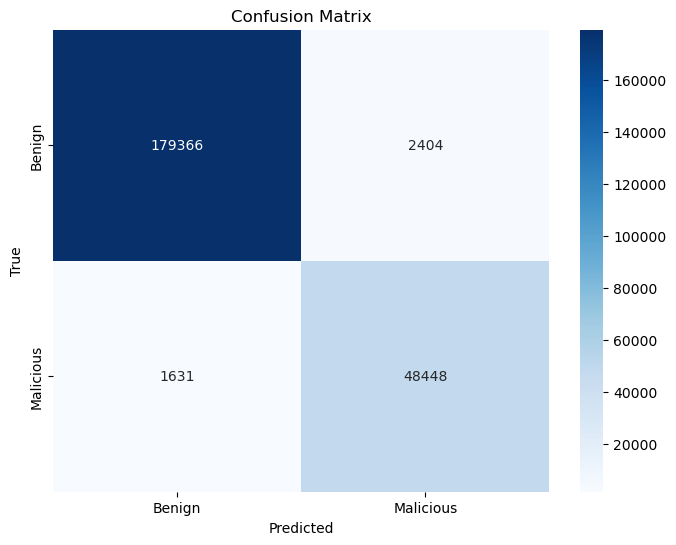

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.26%


## Decision Tree

In [22]:
# Create a Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier()

In [23]:
# Train the classifier on the training data
decision_tree_classifier.fit(x_train, y_train)

DecisionTreeClassifier()

In [24]:
# Make predictions on the testing data
y_pred = decision_tree_classifier.predict(x_test)

In [25]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[181292    478]
 [   391  49688]]


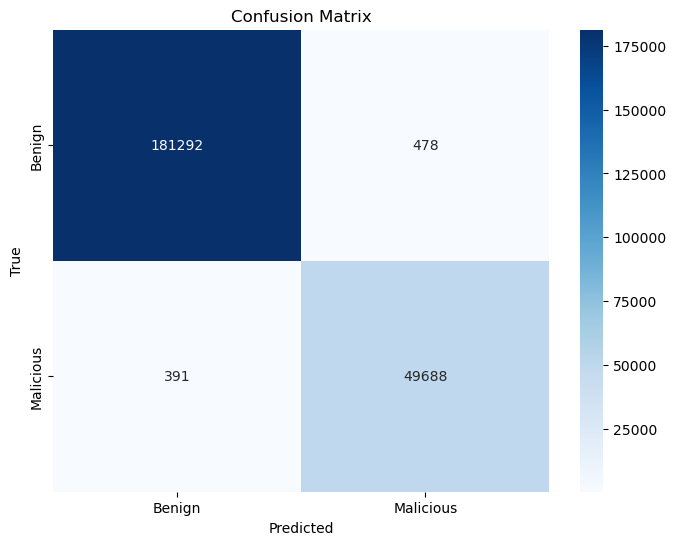

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [32]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.62%


In [27]:
# plot the decision tree + save as png

dot_data = tree.export_graphviz(decision_tree_classifier, out_file=None, max_depth=3, 
                                feature_names=feature_names,  
                                class_names=class_names,
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
type(graph)

graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'